# Bigrams and Trigrams Word Clouds - General Covid-19 dataset 

### trigrams_cloud.py and bigrams_cloud.py

In order to create the word clouds and the bar charts, we need the following packages:

In [1]:
from itertools import tee, islice 
import pandas as pd
import numpy as np
import json
#import sys
import string
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder,TrigramCollocationFinder, TrigramAssocMeasures
from operator import itemgetter
import itertools
import contractions
from nltk.corpus import stopwords
import num2words
from PIL import Image
import altair as alt
import itertools

Then we have defined the following functions to clean the tweets' text:

In [2]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def noamp(text):
    clean = re.sub("&amp", " ",text)
    return (clean)

To read the JSON file that has all the tweets, it is necessary to do:

In [3]:
data = []
with open('dataset/general_result_translated_full.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

### Bigrams

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [4]:
index=0
stop_words = stopwords.words('english')
new_bigram=[]
for element in data:
    data[index]['full_text'] = data[index]['full_text'].lower()                              # Put everything in lowercase
    data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    #data[index]['full_text'] = re.sub("\'\w+", '', data[index]['full_text'])                # Remove everything after '
    data[index]['full_text'] = remove_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_twitter_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_emoticons(data[index]['full_text'])
    data[index]['full_text'] = remove_emoji(data[index]['full_text'])
    data[index]['full_text'] = give_emoji_free_text(data[index]['full_text'])
    data[index]['full_text'] = noamp(data[index]['full_text'])                               # No amp with space
    data[index]['full_text'] = re.sub("#\S+", " ",  data[index]['full_text'])                # Remove hashtags
    data[index]['full_text'] = re.sub("@\S+", " ",  data[index]['full_text'])                # No mentions
    data[index]['full_text'] = data[index]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index]['full_text'] = data[index]['full_text'].encode('ascii', 'ignore').decode()   # No unicode
    data[index]['full_text'] = re.sub("^rt ", " ", data[index]['full_text'])                 # No RT
    data[index]['full_text'] = re.sub('\s{2,}', " ", data[index]['full_text'])               # Remove big spaces
    bigram_tokens=list(nltk.bigrams(nltk.word_tokenize(data[index]['full_text'])))
    #print(bigram_tokens)
    clean_bigram_tokens = [gram for gram in bigram_tokens if not any(stop in gram for stop in stop_words)]
    new_bigram.append(clean_bigram_tokens)
    index=index+1

The dictionary is created:

In [5]:
list_bi=list(itertools.chain.from_iterable(new_bigram))
fdist_bi = dict(nltk.FreqDist(list_bi))
bi = {}
for k,v in fdist_bi.items():
    bi[" ".join(k)] = fdist_bi[k]
    bi[" ".join(k)] = v

#for x, y in bi.items():
#    print(x, y)

We have created a bar chart showing the 15 most frequent bigrams within the dataset:

In [6]:
fdist_sorted_bi = dict(sorted(bi.items(), key=lambda item: item[1], reverse=True))
#print(fdist_sorted)
out_bi = dict(itertools.islice(fdist_sorted_bi.items(), 15))

df_bi = pd.DataFrame.from_dict(out_bi, orient='index').reset_index()
df_bi = df_bi.rename(columns={'index':'bigrams', 0:'count'})
#print(df)
#alt.renderers.enable('altair_viewer',inline=True)


chart = alt.Chart(
    df_bi,
    title = "The 15 most frequent bigrams in the dataset"
).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('bigrams:N',sort='-x'),
    color=alt.Color('count:Q',scale=alt.Scale(scheme="greens"))
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]
).transform_filter(
    (alt.datum.rank < 15)
).properties(width=700, height=300, title = "The 15 most frequent bigrams in the dataset")

chart

alt.Chart(...)

The word cloud is created:

In [7]:
mask=np.array(Image.open('grafici/number_two.jpg'))

wordcloud_bi = WordCloud(
            mask=mask,
            width=mask.shape[1],
            height=mask.shape[0],
            background_color ='white', 
            min_word_length = 3,
            max_words=400,
            font_path = 'grafici/GothamMedium.ttf',
            min_font_size = 10).generate_from_frequencies(bi)

Plot the word cloud:

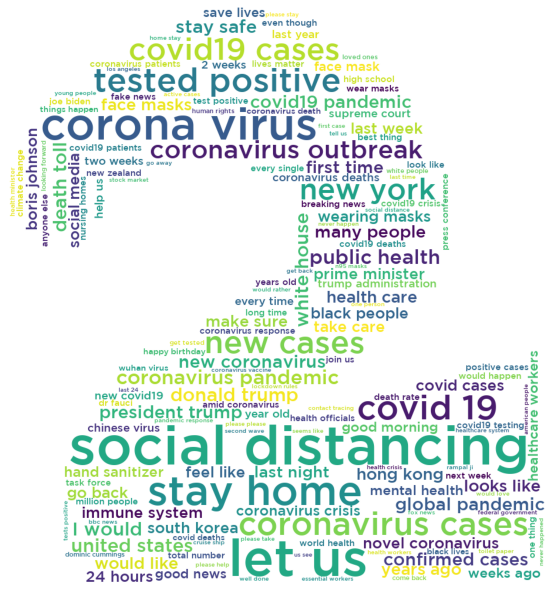

In [8]:
# Plot the Word Cloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_bi) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

### Trigrams

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [9]:
index_tri=0
stop_words_tri = stopwords.words('english')
new_trigram=[]
for element in data:
    data[index_tri]['full_text'] = data[index_tri]['full_text'].lower()                   # Put everything in lowercase
    data[index_tri]['full_text'] = contractions.fix(data[index_tri]['full_text'])
    #data[index_tri]['full_text'] = re.sub("\'\w+", '', data[index_tri]['full_text'])     # Remove everything after '
    data[index_tri]['full_text'] = remove_urls(data[index_tri]['full_text'])
    data[index_tri]['full_text'] = remove_twitter_urls(data[index_tri]['full_text'])
    data[index_tri]['full_text'] = remove_emoticons(data[index_tri]['full_text'])
    data[index_tri]['full_text'] = remove_emoji(data[index_tri]['full_text'])
    data[index_tri]['full_text'] = give_emoji_free_text(data[index_tri]['full_text'])
    data[index_tri]['full_text'] = noamp(data[index_tri]['full_text'])                    # No amp with space
    data[index_tri]['full_text'] = re.sub("#\S+", " ",  data[index_tri]['full_text'])     # Remove hashtags
    data[index_tri]['full_text'] = re.sub("@\S+", " ",  data[index_tri]['full_text'])     # No mentions
    data[index_tri]['full_text'] = data[index_tri]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index_tri]['full_text'] = data[index_tri]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data[index_tri]['full_text'] = re.sub("^rt ", " ", data[index_tri]['full_text'])      # No RT
    data[index_tri]['full_text'] = re.sub(r'\b\d\b', lambda x: num2words.num2words(int(x.group(0))), data[index_tri]['full_text'])
    data[index_tri]['full_text'] = re.sub('\s{2,}', " ", data[index_tri]['full_text'])    # Remove big spaces
    trigram_tokens=list(nltk.trigrams(nltk.word_tokenize(data[index_tri]['full_text'])))
    #print(trigram_tokens)
    clean_trigram_tokens = [gram for gram in trigram_tokens if not any(stop in gram for stop in stop_words_tri)]
    new_trigram.append(clean_trigram_tokens)
    index_tri=index_tri+1

The dictionary is created:

In [10]:
list_tri=list(itertools.chain.from_iterable(new_trigram))
fdist_tri = dict(nltk.FreqDist(list_tri))
tri = {}
for k,v in fdist_tri.items():
    tri[" ".join(k)] = fdist_tri[k]
    tri[" ".join(k)] = v

#for x, y in tri.items():
#    print(x, y)

We have created a bar chart showing the 15 most frequent trigrams within the dataset:

In [11]:
fdist_sorted_tri = dict(sorted(tri.items(), key=lambda item: item[1], reverse=True))
#print(fdist_sorted)
out_tri = dict(itertools.islice(fdist_sorted_tri.items(), 15))

df_tri = pd.DataFrame.from_dict(out_tri, orient='index').reset_index()
df_tri = df_tri.rename(columns={'index':'trigrams', 0:'count'})
#print(df)
#alt.renderers.enable('altair_viewer',inline=True)

c = alt.Chart(
    df_tri,
    title = "The 15 most frequent trigrams in the dataset"
).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('trigrams:N',sort='-x'),
    color=alt.Color('count:Q',scale=alt.Scale(scheme="blues"))
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]
).transform_filter(
    (alt.datum.rank < 15)
).properties(width=700, height=300, title = "The 15 most frequent trigrams in the dataset")

c

alt.Chart(...)

The word cloud is created:

In [12]:
mask_tri=np.array(Image.open('grafici/number_three.jpg'))

wordcloud_tri = WordCloud(
            mask=mask_tri,
            width=mask_tri.shape[1],
            height=mask_tri.shape[0],
            background_color ='white', 
            min_word_length = 3,
            max_words=450,
            font_path = 'grafici/GothamMedium.ttf',
            min_font_size = 10).generate_from_frequencies(tri)

Plot the word cloud:

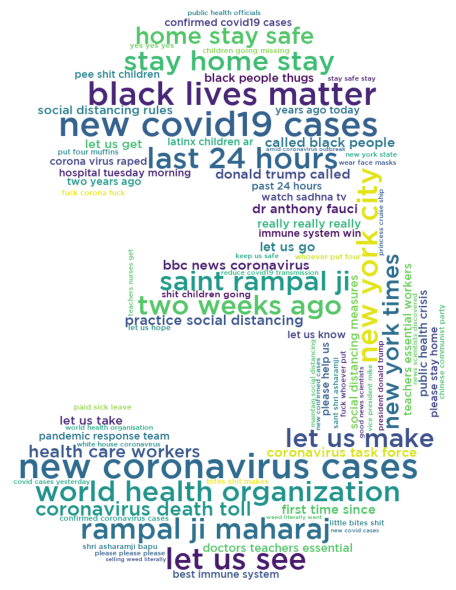

In [13]:
# Plot the Word Cloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_tri) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 